[<- back to main page](implementation.ipynb)

# Example 4: frequency dependent scaling

Instead of choosing a constant scaling as in the previous examples, we choose the frequency dependency

$$\sigma(\omega):=\frac{\frac{\alpha}{\omega}+\beta}{\gamma+\omega\delta},$$
(cf. [(7.13)](dissertation_wess.pdf#equation.7.3.13)).

Choosing this frequency-dependency leads to rational eigenvalue problems, which can be treated using the methods from [Chapter 8](dissertation_wess.pdf#chapter.8) (the implementation is described [here](fq_scaling.ipynb)).

For this example we use again polar coordinates, i.e.,
\begin{align}\xi(\mathbf x)&:=\|\mathbf x\|-1,&
\hat x(\mathbf x)&:=\frac{\mathbf x}{\|\mathbf x\|}\end{align}
(cf. [Remark 3.3](dissertation_wess.pdf#thm.3.3)).

Similar to the previous examples we create a mesh, the necessary FE-spaces, assemble the matrices and solve the according eigenvalue problem. This time we have to use the algorithm for rational problems.

In [1]:
from ngsolve import *
from netgen.geom2d import *
from nonlin_arnoldis import *
from ngsolve.webgui import Draw
from numpy import array,sqrt,loadtxt
from matplotlib.pyplot import plot,show,xlim,ylim,legend


N = 10        #infinite elements
maxh = 0.1     #mesh-size
order = 3      #fem order
shift = 4-0.5j      #shift for Arnoldi algorithm
center = (0.2,0)    #center of inner circle
R = 0.5            #radius of inner circle

#create geometry
geo = SplineGeometry()
geo.AddCircle((0,0),1,leftdomain=1,rightdomain=0,bc='Gamma')
geo.AddCircle(center,R,leftdomain=0,rightdomain=1,bc='inner')


#create mesh
mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(2*order)
Draw(mesh)
Gamma = mesh.Boundaries('Gamma')

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': N…

In [2]:
Gamma = mesh.Boundaries('Gamma')

fes_int = H1(mesh,order=order,complex=True)
fes_surf = H1(mesh,order=order,complex=True,definedon=Gamma)

fes = ProductSpace(fes_int,*( N*[fes_surf]) )

In [3]:
from infinite_elements import *

ie_mass,ie_laplace,__,ie_mass_x,ie_mass_xx,ie_laplace_x,ie_laplace_xx,_ = ie_matrices(N)

ie_laplace_x[0,0]-=1/4

In [4]:
p,q = fes.TnT()
pint, qint = p[0],q[0]
ds_g = ds(definedon=Gamma)

#interior BFs
Mint = BilinearForm(pint*qint*dx,symmtric=True).Assemble()
Sint = BilinearForm(grad(pint)*grad(qint)*dx,symmetric=True).Assemble()

#exterior BFs
M = BilinearForm(sum(ie_mass[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0),symmetric=True).Assemble()
Mx = BilinearForm(sum(ie_mass_x[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_mass_x[i,j])>0),symmetric=True).Assemble()
Mxx = BilinearForm(sum(ie_mass_xx[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_mass_xx[i,j])>0),symmetric=True).Assemble()

S = BilinearForm(sum(ie_laplace[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_laplace[i,j])>0),symmetric=True).Assemble()
Sx = BilinearForm(sum(ie_laplace_x[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_laplace_x[i,j])>0),symmetric=True).Assemble()
Sxx = BilinearForm(
    sum(ie_laplace_xx[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_laplace_xx[i,j])>0)
    -sum(1/4*ie_mass[i,j]*p[i]*q[j]*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0)
                      ,symmetric=True).Assemble()

Ssurf = BilinearForm(sum(ie_mass[i,j]*p[i].Trace().Deriv()*q[j].Trace().Deriv()*ds_g
                     for i in range(N+1) for j in range(N+1) if abs(ie_mass[i,j])>0),symmetric=True).Assemble()

In [5]:
def mobius_scaling(alpha,beta,gamma,delta):
        gf = GridFunction(fes,multidim=50)

        Ph=array([
            [0,0,0,0,2,0,0,0,1],
            [0,0,0,0,0,1,1,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,-2,0,0,0,0,0,0,0],
            [0,0,-1,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            ])
        Pt=array([
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,1,0],
            ])
        Th=array([
            [-beta,gamma,-alpha, 0, 0, 0, 0,0, 0, 0],
            [1 ,0, 0, 0, 0, 0, 0,0, 0, 0],
            [gamma ,0, 0,-beta,-alpha, 0, 0,0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0,0, 0, 0],
            [alpha ,0, 0, 0, 0,-gamma, 0,0, 0, 0],
            [0 ,0, 0, 0, 0, alpha,-gamma,0, 0, 0],
            [0 ,0, 0, 0, 0, 0,-beta,gamma,-alpha, 0],
            [0 ,0, 0, 0, 0, 0, 1,0, 0, 0],
            [0 ,0, 0, 0, 0, 0, 0,0, 0, 1]
            ])
        Tt=array([
            [0 ,-delta,0, 0, 0, 0, 0,0, 0, 0],
            [0 , 0,1, 0, 0, 0, 0,0, 0, 0],
            [-delta, 0,0, 0, 0, 0, 0,0, 0, 0],
            [0,  0,0, 0, 1, 0, 0,0, 0, 0],
            [-beta, 0,0, 0, 0, delta, 0,0, 0, 0],
            [0 , 0,0, 0, 0,-beta, delta,0, 0, 0],
            [0 , 0,0, 0, 0, 0, 0,-delta, 0, 0],
            [0 , 0,0, 0, 0, 0, 0,0, 1, 0],
            [1 ,0, 0, 0, 0, 0, 0,0, 0, 0]
            ])

        saialp=SaiALP([M.mat,Mx.mat,Mxx.mat,S.mat,Sx.mat,Sxx.mat,Ssurf.mat,Mint.mat,Sint.mat],Ph.T,Pt.T,Th,Tt,shift,fes.FreeDofs())
        saialp.CalcInverse('sparsecholesky')
        saialp.CalcKrylow(200)
        lam=saialp.SolveHessenberg(gf.vecs,100)    
        return lam

In [6]:
#frequency-independent scaling

lam_0 = mobius_scaling(0,0.2+1j,1,0)
lam_v = mobius_scaling(0.5+0.5j,0,1,0)
lam_c = mobius_scaling(0,1j,1,0.2)
lam_b = mobius_scaling(1+1j,0.1,1,0)



SaiALP:__init__ called
initialized linearizeable EVP with dimensions n=8, m=9, N=6521 in 0.0016845479985931888 seconds
called CalcInverse
inverted in 0.09904093699879013 seconds
CalcKrylow called
building Krylow space of dimension 200
starting iteration
Krylowspace built in 7.478176413998881 seconds
called SolveHessenberg
solved Hessenberg EVP in 0.2957404509979824 seconds
calculating 50 big vectors
SaiALP:__init__ called
initialized linearizeable EVP with dimensions n=8, m=9, N=6521 in 0.0007159639972087462 seconds
called CalcInverse
inverted in 0.11231642799975816 seconds
CalcKrylow called
building Krylow space of dimension 200
starting iteration
Krylowspace built in 7.329905923998012 seconds
called SolveHessenberg
solved Hessenberg EVP in 0.40468330400108243 seconds
calculating 50 big vectors
SaiALP:__init__ called
initialized linearizeable EVP with dimensions n=8, m=9, N=6521 in 0.0007390390019281767 seconds
called CalcInverse
inverted in 0.09737494400178548 seconds
CalcKrylow call

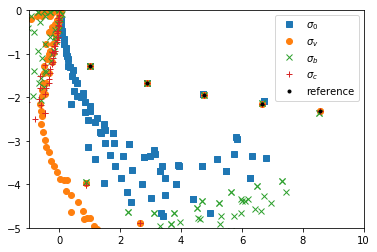

In [7]:
plot(lam_0.real,lam_0.imag,'s',label='$\sigma_0$')
plot(lam_v.real,lam_v.imag,'o',label='$\sigma_v$')
plot(lam_b.real,lam_b.imag,'x',label='$\sigma_b$')
plot(lam_c.real,lam_c.imag,'+',label='$\sigma_c$')

loaded=loadtxt('dhankel_1_zeros.out')
ref=(loaded[:,0]+1j*loaded[:,1])/R
plot(ref.real,ref.imag,'.k',label='reference')

xlim((-1,10))
ylim((-5,0))
legend()

[<- back to main page](implementation.ipynb)